The objective of this notebook is to show how to read and plot the data obtained with a profiler (or profiling buoy).

In [1]:
%matplotlib inline
import netCDF4
from netCDF4 import num2date
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.basemap import Basemap

# Data reading

The data file is located in the *datafiles* directory.

In [2]:
datadir = './datafiles/'
datafile = 'GL_PR_PF_3900150.nc'

We extract only the spatial coordinates:

In [3]:
with netCDF4.Dataset(datadir + datafile) as nc:
    lon = nc.variables['LONGITUDE'][:]
    lat = nc.variables['LATITUDE'][:]

# Location of the profiles

In this first plot we want to see the location of the profiles obtained with the profiler.

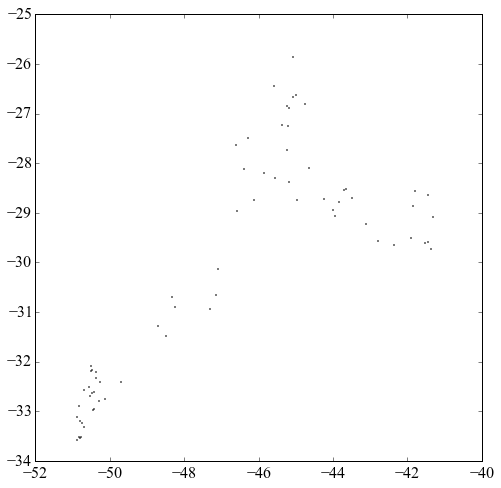

In [4]:
mpl.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.plot(lon, lat, 'ko', ms=1)
plt.show()

The figure can be improved by adding the landmask and coastline.

# Plot on a map

The first thing to do is to create a projection using basemap. We can obtain the bounding box from the previous plot:

In [5]:
lonmin, lonmax = ax.get_xlim()
latmin, latmax = ax.get_ylim()

then we create the projection, slightly enlarging the longitude extension:

In [69]:
m = Basemap(projection='merc', llcrnrlat=latmin, urcrnrlat=latmax,
            llcrnrlon=lonmin-2., urcrnrlon=lonmax+2., lat_ts=0.5*(lon.min()+lon.max()), resolution='i')

The new figure is generated similarly to the previous one:

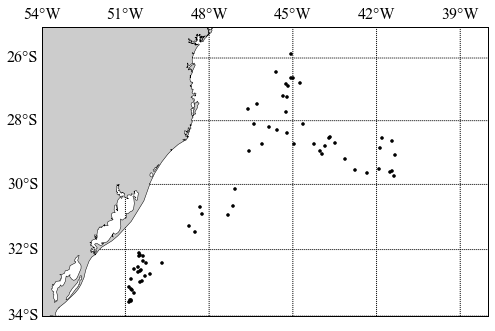

In [71]:
lon2, lat2 = m(lon, lat)
fig = plt.figure(figsize=(8,8))
m.plot(lon2, lat2, 'ko', ms=3)

m.drawcoastlines(linewidth=0.5, zorder=3)
m.fillcontinents(zorder=2)

m.drawparallels(np.arange(-90.,91.,2.), labels=[1,0,0,0], zorder=1)
m.drawmeridians(np.arange(-180.,181.,3.), labels=[0,0,1,0], zorder=1)
plt.show()

# Profile plot

We extract the salinity and the vertical coordinate used in the profile, the pressure in this case.<br/>
For the x-dimension, we will use the time.

In [72]:
with netCDF4.Dataset(datadir + datafile) as nc:
    pressure = nc.variables['PRES'][:]
    pressure_name = nc.variables['PRES'].long_name
    pressure_units = nc.variables['PRES'].units
    salinity = nc.variables['PSAL'][:]
    salinity_name = nc.variables['PSAL'].long_name
    salinity_units = nc.variables['PSAL'].units
    time = nc.variables['TIME'][:]
    time_units = nc.variables['TIME'].units
    time_name = nc.variables['TIME'].long_name
    dates = num2date(time, units=time_units)

We also have to set the colormap and the limits for the salinity.

In [10]:
cmap = plt.cm.Spectral_r
norm = colors.Normalize(vmin=34, vmax=36)

We specify the coordinates (time and pressure) and the salinity as the arguments of the scatter plot:
* s=10 indicate the size of the dots,
* c=salinity indicates which variable is used as the z-dimension (color)
* edgecolor='None' means that no color is applied around the edge of the marker
* cmap=cmap sets the colormap to cmap, defined before and
* norm=norm sets the limits for the color scale.

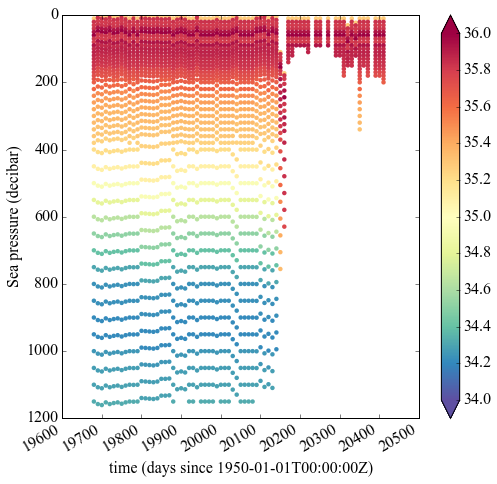

In [73]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
for ntime in range(0, len(time)):
    plt.scatter(time[ntime]*np.ones_like(pressure[ntime,]), pressure[ntime,:], 
                s=20, c=salinity[0,:], edgecolor='None', cmap=cmap, norm=norm)
plt.ylim(0.0, 1200)
plt.gca().invert_yaxis()
plt.colorbar(extend='both')
fig.autofmt_xdate()
plt.ylabel("%s (%s)" % (pressure_name, pressure_units))
plt.xlabel("%s (%s)" % (time_name, time_units))
plt.show()

The salinity has it's highest values near surface, but we can also see an increase between 800 and 1000 m depth. 

# T-S diagram

For the temperature-salinity (T-S) diagram we need to load the temperature variable. 

In [30]:
with netCDF4.Dataset(datadir + datafile) as nc:
    temperature = nc.variables['TEMP'][:]
    temperature_name = nc.variables['TEMP'].long_name
    temperature_units = nc.variables['TEMP'].units

The x and y labels for the plot are directly taken from the netCDF variable attributes.

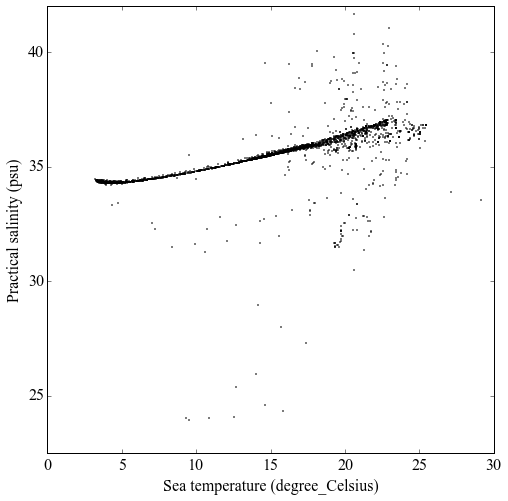

In [37]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.plot(temperature, salinity, 'k.', markersize=2)
plt.xlabel("%s (%s)" % (temperature_name, temperature_units))
plt.ylabel("%s (%s)" % (salinity_name, salinity_units))
plt.ylim(22.5, 42)
plt.show()

# Adjusted variables

The profiler files also contain adjusted variables (pressure, temperature, salinity) which correspond to the variable after the application of a correction.
We will repeat the T-S diagram with the adjusted variables.

In [46]:
with netCDF4.Dataset(datadir + datafile) as nc:
    temperature_adj = nc.variables['TEMP_ADJUSTED'][:]
    temperature_adj_name = nc.variables['TEMP_ADJUSTED'].long_name
    salinity_adj = nc.variables['PSAL_ADJUSTED'][:]
    salinity_adj_name = nc.variables['PSAL_ADJUSTED'].long_name

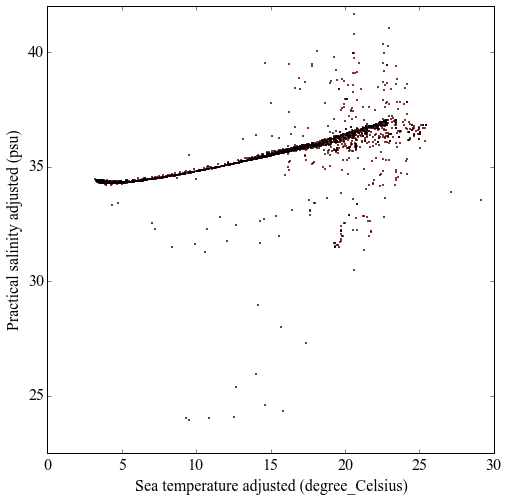

In [47]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.plot(temperature, salinity, 'r.', markersize=2)
plt.plot(temperature_adj, salinity_adj, 'k.', markersize=2)
plt.xlabel("%s (%s)" % (temperature_adj_name, temperature_units))
plt.ylabel("%s (%s)" % (salinity_adj_name, salinity_units))
plt.ylim(22.5, 42)
plt.show()

# 3-D plot

We illustrate with a simple example how to have a 3-dimensional representation of the profiles.<br/>
First we import the required modules.

In [67]:
from mpl_toolkits.mplot3d import Axes3D

Then the plot is easily obtained by specifying the coordinates (x, y, z) and the variables (salinity) to be plotted.

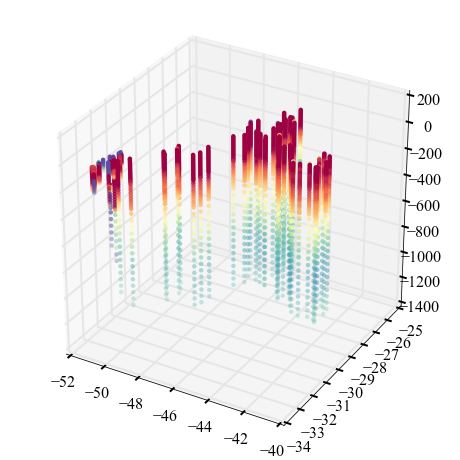

In [68]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for ntime in range(0, ntimes):
    plt.scatter(lon[ntime]*np.ones(ndepths), lat[ntime]*np.ones(ndepths), zs=-pressure[ntime,:], zdir='z', 
                s=20, c=salinity[ntime,:], edgecolor='None', cmap=cmap, norm=norm)
plt.show()